<a href="https://colab.research.google.com/github/TINF-DeepfakeEvaluierung/Evaluation-von-Methoden-zur-Erkennung-von-Deepfakes/blob/main/FTCN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/TINF-DeepfakeEvaluierung/FTCN.git
%cd "FTCN"
!pip install simplejson
!pip install filterpy
!pip install fvcore
!pip install einops

Cloning into 'FTCN'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 178 (delta 46), reused 5 (delta 5), pack-reused 100
Receiving objects: 100% (178/178), 33.42 MiB | 21.77 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/FTCN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=5461c50a3c0810c27b9e529fe25d19b44623810687352e37a6b286115ccdfadb
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Connect Google Cloud
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse
# Mount a Cloud Storage bucket or location, without the gs:// prefix.
mount_path = "deepfake_detection_datasets"  # or a location like "my-bucket/path/to/mount"
local_path = f"/content/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2659  100  2659    0     0  29293      0 --:--:-- --:--:-- --:--:-- 29544
OK
46 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 46 not upgraded.
Need to get 10.4 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121920 files and directories currently installed.)
Preparing to unpack .../gcsfuse_2.0.1_amd64.deb ...
Unpacking gcsfuse (2.0.1) ...
Setting up g

In [ ]:
!mkdir /content/FTCN/checkpoints
!cp "/content/deepfake_detection_datasets/FTCN_(model)/ftcn_tt.pth" "/content/FTCN/checkpoints/"

In [ ]:
import torch
import os
import numpy as np
import sys
from tqdm import tqdm
import json
from itertools import islice
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import normalize

sys.path.append('..')

from utils.plugin_loader import PluginLoader
from config import config as cfg
from test_tools.common import detect_all, grab_all_frames
from test_tools.utils import get_crop_box
from test_tools.ct.operations import find_longest, multiple_tracking
from test_tools.faster_crop_align_xray import FasterCropAlignXRay
from test_tools.supply_writer import SupplyWriter
from test_on_raw_video import predict_deepfake_video

In [ ]:
!python test_on_raw_video.py /content/deepfake_detection_datasets/VASA-1/10.mp4 --out_dir ./

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
64
/content/deepfake_detection_datasets/VASA-1/10.mp4 Score: 0.0003604665449448276
Output File ./10.avi saved


# FF++

In [ ]:
ffpp_dir = "/content/deepfake_detection_datasets/FFPP/"
dataset = "FaceForensics++"

In [ ]:
# images_per_class should be devidable by 6
def detect_ffpp_deepfakes(ffpp_dir, images_per_class=30):
    # Initialize arrays to store scores for real and fake videos.
    scores_real = np.array([])
    scores_fake = np.array([])
    # Dictionaries to keep track of how many files have been processed in each subfolder.
    manipulated_predicted_count = {}
    original_predicted_count = {}

    # Calculate the number of files to be processed per subfolder based on the folder type.
    files_per_manipulated_subfolder = images_per_class / 6
    files_per_original_subfolder = images_per_class / 2

    # Total number of files targeted for processing from all subfolders.
    total_files_to_process = 2 * images_per_class
    processed_files = 0  # Counter for the number of files processed.

    # Set up a progress bar with the total number of files to process.
    pbar = tqdm(total=total_files_to_process)

    # Walk through the directory structure of the given path.
    for root, _, files in os.walk(ffpp_dir):
        for file in files:
            # Stop processing if the number of processed files meets the target.
            if processed_files >= total_files_to_process:
                break

            # Process only MP4 video files.
            if file.endswith('.mp4'):
                vid_path = os.path.join(root, file)
                rel_path = os.path.relpath(vid_path, ffpp_dir)
                path_parts = rel_path.split(os.sep)
                # Dynamically update the progress bar description.
                pbar.set_description(f"Processing {path_parts[-1]}")

                # Check if the video is from a manipulated or original sequence based on folder names.
                is_manipulated = path_parts[0] == 'manipulated_sequences'
                subfolder_path = os.path.join(path_parts[0], path_parts[1])

                # Process videos from manipulated sequences.
                if is_manipulated:
                    # Ensure not to process more videos than the set limit for the subfolder.
                    if manipulated_predicted_count.get(subfolder_path, 0) < files_per_manipulated_subfolder:
                        faces_pred, _, _, _ = predict_deepfake_video(vid_path)
                        scores_fake = np.append(scores_fake, faces_pred)
                        manipulated_predicted_count[subfolder_path] = manipulated_predicted_count.get(subfolder_path, 0) + 1
                        processed_files += 1
                        pbar.update(1)
                # Process videos from original sequences.
                else:
                    if original_predicted_count.get(subfolder_path, 0) < files_per_original_subfolder:
                        faces_pred, _, _, _ = predict_deepfake_video(vid_path)
                        scores_real = np.append(scores_real, faces_pred)
                        original_predicted_count[subfolder_path] = original_predicted_count.get(subfolder_path, 0) + 1
                        processed_files += 1
                        pbar.update(1)

        # Break the outer loop if the processing limit is reached.
        if processed_files >= total_files_to_process:
            break

    # Close the progress bar upon completion.
    pbar.close()
    # Return the arrays containing the fake and real scores.
    return scores_fake, scores_real

In [ ]:
score_fake, score_real = detect_ffpp_deepfakes(ffpp_dir)

Processing 01_11__talking_against_wall__9229VVZ3.mp4:   0%|          | 0/60 [00:02<?, ?it/s]

[0424 19:00:59 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:00:59 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



testing: 100%|██████████| 269/269 [01:10<00:00,  3.83it/s]
Processing 01_27__outside_talking_still_laughing__ZYCZ30C0.mp4:   2%|▏         | 1/60 [01:45<1:43:23, 105.15s/it]

0.8233949097849733
[0424 19:02:42 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:02:42 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



testing: 100%|██████████| 269/269 [00:57<00:00,  4.69it/s]
Processing 02_06__walking_down_indoor_hall_disgust__U6MDWIHG.mp4:   3%|▎         | 2/60 [03:10<1:30:25, 93.55s/it]

0.8838156916782759
[0424 19:04:07 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:04:07 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 2
0 300
0 300
sampling clips from super clips [300, 300]



testing: 100%|██████████| 538/538 [02:13<00:00,  4.03it/s]
Processing 02_15__talking_against_wall__HTG660F8.mp4:   5%|▌         | 3/60 [05:52<1:58:24, 124.63s/it]            

0.44533866602274447
[0424 19:06:49 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:06:49 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



testing: 100%|██████████| 269/269 [01:12<00:00,  3.70it/s]
Processing 03_11__talking_against_wall__P08VGHTA.mp4:   7%|▋         | 4/60 [07:32<1:47:12, 114.87s/it]

0.968935655423035
[0424 19:08:29 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:08:29 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



testing: 100%|██████████| 269/269 [01:09<00:00,  3.89it/s]
Processing 27_02__walk_down_hall_angry__FV8M8O2C.mp4:   8%|▊         | 5/60 [09:08<1:39:01, 108.04s/it]

0.9999476795302891


Processing 033_097.mp4:   8%|▊         | 5/60 [09:09<1:39:01, 108.04s/it]                              

[0424 19:10:06 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:10:06 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 035_036.mp4:  10%|█         | 6/60 [09:59<1:19:52, 88.76s/it]

0.9999643125498605
[0424 19:10:56 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:10:56 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 036_035.mp4:  12%|█▏        | 7/60 [10:58<1:09:44, 78.96s/it]

0.9998005788122412
[0424 19:11:55 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:11:55 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 044_945.mp4:  13%|█▎        | 8/60 [11:54<1:02:05, 71.64s/it]

0.9980665662474791
[0424 19:12:51 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:12:51 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 055_147.mp4:  15%|█▌        | 9/60 [13:20<1:04:43, 76.15s/it]

0.9999661950816895
[0424 19:14:17 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:14:17 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 994_986.mp4:  17%|█▋        | 10/60 [14:23<1:00:07, 72.14s/it]

0.9997210648866391


Processing 033_097.mp4:  17%|█▋        | 10/60 [14:25<1:00:07, 72.14s/it]

[0424 19:15:22 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:15:22 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 035_036.mp4:  18%|█▊        | 11/60 [15:17<54:27, 66.69s/it]

0.9996713437555448
[0424 19:16:14 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:16:14 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 036_035.mp4:  20%|██        | 12/60 [16:17<51:44, 64.68s/it]

0.999933825549583
[0424 19:17:15 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:17:15 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 044_945.mp4:  22%|██▏       | 13/60 [17:15<48:55, 62.46s/it]

0.9999536178369062
[0424 19:18:12 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:18:12 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 055_147.mp4:  23%|██▎       | 14/60 [18:43<53:58, 70.40s/it]

0.9999084368514306
[0424 19:19:41 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:19:41 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 994_986.mp4:  25%|██▌       | 15/60 [19:48<51:26, 68.58s/it]

0.9999554627003723


Processing 033_097.mp4:  25%|██▌       | 15/60 [19:49<51:26, 68.58s/it]

[0424 19:20:47 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:20:47 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 035_036.mp4:  27%|██▋       | 16/60 [20:42<47:02, 64.15s/it]

0.9346398363880065
[0424 19:21:39 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:21:39 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 036_035.mp4:  28%|██▊       | 17/60 [21:41<44:53, 62.65s/it]

0.9964424626534756
[0424 19:22:38 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:22:38 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 044_945.mp4:  30%|███       | 18/60 [22:39<42:51, 61.23s/it]

0.6813208051640401
[0424 19:23:36 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:23:36 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 055_147.mp4:  32%|███▏      | 19/60 [24:07<47:24, 69.38s/it]

0.90300386727244
[0424 19:25:04 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:25:04 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 994_986.mp4:  33%|███▎      | 20/60 [25:11<45:11, 67.79s/it]

0.8115499473227098


Processing 033_097.mp4:  33%|███▎      | 20/60 [25:12<45:11, 67.79s/it]

[0424 19:26:09 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:26:09 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 035_036.mp4:  35%|███▌      | 21/60 [26:05<41:21, 63.63s/it]

0.999910204162385
[0424 19:27:02 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:27:02 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 036_035.mp4:  37%|███▋      | 22/60 [27:05<39:34, 62.48s/it]

0.9926044010318344
[0424 19:28:02 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:28:02 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 044_945.mp4:  38%|███▊      | 23/60 [28:03<37:38, 61.04s/it]

0.8825496463278191
[0424 19:29:00 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:29:00 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 055_147.mp4:  40%|████      | 24/60 [29:30<41:27, 69.09s/it]

0.9999592109240564
[0424 19:30:28 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:30:28 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 994_986.mp4:  42%|████▏     | 25/60 [30:36<39:36, 67.91s/it]

0.9999589304055423


Processing 033_097.mp4:  42%|████▏     | 25/60 [30:36<39:36, 67.91s/it]

[0424 19:31:34 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:31:34 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 035_036.mp4:  43%|████▎     | 26/60 [31:30<36:06, 63.72s/it]

0.9980459973271452
[0424 19:32:27 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:32:27 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 036_035.mp4:  45%|████▌     | 27/60 [32:30<34:27, 62.65s/it]

0.9999293806827645
[0424 19:33:27 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:33:27 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 044_945.mp4:  47%|████▋     | 28/60 [33:28<32:47, 61.47s/it]

0.9994150318177659
[0424 19:34:26 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:34:26 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 055_147.mp4:  48%|████▊     | 29/60 [34:57<36:00, 69.69s/it]

0.9993102058602088
[0424 19:35:55 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:35:55 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 994_986.mp4:  50%|█████     | 30/60 [36:03<34:15, 68.53s/it]

0.9999476573724286


Processing 01__hugging_happy.mp4:  50%|█████     | 30/60 [36:05<34:15, 68.53s/it]

[0424 19:37:02 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:37:02 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 01__kitchen_pan.mp4:  52%|█████▏    | 31/60 [37:33<36:16, 75.04s/it]  

0.25215907230725265
[0424 19:38:31 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:38:31 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 0
0 20
20 300
sampling clips from super clips [20, 280]



Processing 01__kitchen_still.mp4:  53%|█████▎    | 32/60 [39:19<39:14, 84.10s/it]

0.40362243498871975
[0424 19:40:16 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:40:16 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 01__outside_talking_pan_laughing.mp4:  55%|█████▌    | 33/60 [40:58<39:58, 88.84s/it]

0.020055956166663818
[0424 19:41:56 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:41:56 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 0
6 300
sampling clips from super clips [294]



testing: 100%|██████████| 263/263 [00:58<00:00,  4.50it/s]
Processing 01__outside_talking_still_laughing.mp4:  57%|█████▋    | 34/60 [42:25<38:09, 88.06s/it]

0.39725436604543707
[0424 19:43:22 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:43:22 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



testing: 100%|██████████| 269/269 [00:59<00:00,  4.52it/s]
Processing 01__walking_outside_cafe_disgusted.mp4:  58%|█████▊    | 35/60 [43:51<36:30, 87.63s/it]

0.05141284208980408
[0424 19:44:49 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:44:49 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 02__exit_phone_room.mp4:  60%|██████    | 36/60 [45:13<34:19, 85.81s/it]               

0.4170996650720087
[0424 19:46:10 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:46:10 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 0
2 300
sampling clips from super clips [298]



Processing 02__meeting_serious.mp4:  62%|██████▏   | 37/60 [46:28<31:36, 82.47s/it]

0.21577105824804532
[0424 19:47:25 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:47:25 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 3
0 300
0 300
0 300
sampling clips from super clips [300, 300, 300]



Processing 02__talking_against_wall.mp4:  63%|██████▎   | 38/60 [49:27<40:54, 111.56s/it]

0.06442307800534312
[0424 19:50:24 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:50:24 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



testing: 100%|██████████| 269/269 [01:13<00:00,  3.65it/s]
Processing 02__walking_and_outside_surprised.mp4:  65%|██████▌   | 39/60 [51:08<37:56, 108.40s/it]

0.0029978013057303902
[0424 19:52:05 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:52:05 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 2
0 300
0 300
sampling clips from super clips [300, 300]



testing: 100%|██████████| 538/538 [02:26<00:00,  3.68it/s]
Processing 02__walking_down_indoor_hall_disgust.mp4:  67%|██████▋   | 40/60 [54:06<43:03, 129.18s/it]

0.45603879499958905
[0424 19:55:03 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:55:03 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 2
0 300
0 300
sampling clips from super clips [300, 300]



testing: 100%|██████████| 538/538 [02:15<00:00,  3.97it/s]
Processing 02__walking_down_street_outside_angry.mp4:  68%|██████▊   | 41/60 [56:50<44:14, 139.70s/it]

0.4531960132471829
[0424 19:57:47 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:57:47 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 0
0 64
64 300
sampling clips from super clips [64, 236]



Processing 03__exit_phone_room.mp4:  70%|███████   | 42/60 [57:55<35:13, 117.40s/it]                  

0.9677391663318923
[0424 19:58:53 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 19:58:53 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 03__hugging_happy.mp4:  72%|███████▏  | 43/60 [59:15<30:01, 105.99s/it]  

0.24739862368146212
[0424 20:00:12 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:00:12 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 03__outside_talking_pan_laughing.mp4:  73%|███████▎  | 44/60 [1:00:48<27:15, 102.20s/it]

0.37559139589302165
[0424 20:01:45 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:01:45 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 0
6 300
sampling clips from super clips [294]



testing: 100%|██████████| 263/263 [00:54<00:00,  4.84it/s]
Processing 28__walking_outside_cafe_disgusted.mp4:  75%|███████▌  | 45/60 [1:02:11<24:07, 96.52s/it]   

0.113267092970855


Processing 008.mp4:  75%|███████▌  | 45/60 [1:02:14<24:07, 96.52s/it]                               

[0424 20:03:12 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:03:12 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 033.mp4:  77%|███████▋  | 46/60 [1:03:08<19:43, 84.54s/it]

0.00019166023625934248
[0424 20:04:05 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:04:05 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 035.mp4:  78%|███████▊  | 47/60 [1:04:03<16:24, 75.75s/it]

0.13111069835806838
[0424 20:05:00 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:05:00 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 036.mp4:  80%|████████  | 48/60 [1:05:08<14:31, 72.63s/it]

0.570013648750508
[0424 20:06:06 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:06:06 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 044.mp4:  82%|████████▏ | 49/60 [1:06:11<12:46, 69.67s/it]

0.0027365020493890003
[0424 20:07:08 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:07:08 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 046.mp4:  83%|████████▎ | 50/60 [1:07:43<12:43, 76.34s/it]

0.0007985420446431453
[0424 20:08:40 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:08:40 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 054.mp4:  85%|████████▌ | 51/60 [1:09:12<12:01, 80.20s/it]

0.0016450374513451978
[0424 20:10:10 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:10:10 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 055.mp4:  87%|████████▋ | 52/60 [1:10:14<09:58, 74.79s/it]

0.00017832017190433946
[0424 20:11:12 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:11:12 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 062.mp4:  88%|████████▊ | 53/60 [1:11:22<08:29, 72.75s/it]

0.0003805808778705623
[0424 20:12:20 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:12:20 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 066.mp4:  90%|█████████ | 54/60 [1:12:22<06:52, 68.67s/it]

0.0023740981737403613
[0424 20:13:19 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:13:19 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 071.mp4:  92%|█████████▏| 55/60 [1:13:22<05:30, 66.13s/it]

0.000360975622479803
[0424 20:14:19 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:14:19 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 096.mp4:  93%|█████████▎| 56/60 [1:14:25<04:21, 65.34s/it]

0.016516809538699214
[0424 20:15:23 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:15:23 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 097.mp4:  95%|█████████▌| 57/60 [1:15:47<03:30, 70.14s/it]

0.0049728188985810684
[0424 20:16:44 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:16:44 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 101.mp4:  97%|█████████▋| 58/60 [1:16:44<02:12, 66.29s/it]

0.021332101373266573
[0424 20:17:41 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:17:41 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 107.mp4:  98%|█████████▊| 59/60 [1:17:47<01:05, 65.20s/it]

0.003839465886031816
[0424 20:18:44 @plugin_loader.py:46] Loading Classifier from I3D_Temporal_Var_Fix_Dropout_Tt_Cfg plugin...
[0424 20:18:44 @plugin_loader.py:50] <module 'model.classifier.i3d_temporal_var_fix_dropout_tt_cfg' from '/content/FTCN/model/classifier/i3d_temporal_var_fix_dropout_tt_cfg.py'>Classifier
64
detecting
detect finished
Number of frames detected:  300
split into super clips
full_tracks 1
0 300
sampling clips from super clips [300]



Processing 107.mp4: 100%|██████████| 60/60 [1:18:47<00:00, 78.79s/it]

0.00015419171463910638


# DFDC

In [ ]:
dfdc_dir = "/content/deepfake_detection_datasets/DFDC/train_sample_videos"
dataset = "DFDC"

In [ ]:
# videos_per_class can not be bigger then 77 because there are only 77 real videos
def detect_dfdc_deepfake(deepfake_folder, videos_per_class=30):
  metadata_file = deepfake_folder + "/metadata.json"
  video_count = {'REAL': 0, 'FAKE': 0}
  pbar = tqdm(total=videos_per_class*2)

  with open(metadata_file, 'r') as file:
      metadata = json.load(file)

  scores_real = np.array([]);
  scores_fake = np.array([]);
  for deepfake, properties in metadata.items():
    if video_count[properties['label']] < videos_per_class:
      vid_path = os.path.join(deepfake_folder, deepfake)
      faces_pred, _, _, _ = predict_deepfake_video(vid_path)

      if properties['label'] == "FAKE":
        scores_fake = np.append(scores_fake, faces_pred.mean())
        video_count['FAKE'] += 1
      else:
        scores_real = np.append(scores_real, faces_pred.mean())
        video_count['REAL'] += 1
      pbar.update(1)

  pbar.close()
  return scores_fake, scores_real

In [ ]:
score_fake, score_real = detect_dfdc_deepfake(dfdc_dir)

  0%|          | 0/60 [00:00<?, ?it/s]

64


  2%|▏         | 1/60 [02:13<2:11:23, 133.61s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aagfhgtpmv.mp4 Score: 0.7028860694341029
64


  3%|▎         | 2/60 [04:13<2:01:18, 125.48s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aapnvogymq.mp4 Score: 0.8506928842590921
64


  5%|▌         | 3/60 [05:36<1:40:47, 106.09s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/abarnvbtwb.mp4 Score: 0.31284040386280476
64


  7%|▋         | 4/60 [06:38<1:22:41, 88.60s/it] 

/content/deepfake_detection_datasets/DFDC/train_sample_videos/abofeumbvv.mp4 Score: 0.7574437368647317
64


  8%|▊         | 5/60 [07:51<1:16:14, 83.17s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/abqwwspghj.mp4 Score: 0.7318209747101793
64


 10%|█         | 6/60 [08:53<1:08:19, 75.91s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/acifjvzvpm.mp4 Score: 0.9664356859200063
64


 12%|█▏        | 7/60 [10:04<1:05:34, 74.23s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/acqfdwsrhi.mp4 Score: 0.5849449847985863
64


 13%|█▎        | 8/60 [11:28<1:07:00, 77.31s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/acxnxvbsxk.mp4 Score: 0.9935078536710774
64


 15%|█▌        | 9/60 [13:42<1:20:47, 95.04s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/acxwigylke.mp4 Score: 0.524225272707622
64


 17%|█▋        | 10/60 [15:08<1:16:53, 92.27s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aczrgyricp.mp4 Score: 0.6875430126172459
64


 18%|█▊        | 11/60 [16:11<1:08:09, 83.47s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/adhsbajydo.mp4 Score: 0.6770837999963406
64


 20%|██        | 12/60 [17:50<1:10:30, 88.13s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/adohikbdaz.mp4 Score: 0.5168738811035908
64


 22%|██▏       | 13/60 [19:08<1:06:30, 84.91s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/adylbeequz.mp4 Score: 0.998841923408792
64


 23%|██▎       | 14/60 [20:09<59:35, 77.73s/it]  

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aelfnikyqj.mp4 Score: 0.0023036664423498597
64


 25%|██▌       | 15/60 [21:23<57:26, 76.58s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aelzhcnwgf.mp4 Score: 0.999830493253403
64


 27%|██▋       | 16/60 [22:45<57:24, 78.29s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aettqgevhz.mp4 Score: 0.8518271084695701
64


 28%|██▊       | 17/60 [24:00<55:23, 77.30s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aevrfsexku.mp4 Score: 0.8674617654550474
64


 30%|███       | 18/60 [25:28<56:18, 80.43s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/afoovlsmtx.mp4 Score: 0.00020576301625333416
64


 32%|███▏      | 19/60 [26:42<53:46, 78.69s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/agdkmztvby.mp4 Score: 0.9986389804506833
64


 33%|███▎      | 20/60 [27:43<48:54, 73.36s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/agqphdxmwt.mp4 Score: 0.9990253475075761
64


 35%|███▌      | 21/60 [28:44<45:11, 69.53s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/agrmhtjdlk.mp4 Score: 0.4848020354519552
64


 37%|███▋      | 22/60 [30:10<47:16, 74.64s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/ahbweevwpv.mp4 Score: 0.727433951010713
64


 38%|███▊      | 23/60 [31:14<43:57, 71.28s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/ahdbuwqxit.mp4 Score: 0.9657373453549293
64


 40%|████      | 24/60 [32:38<45:02, 75.06s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/ahfazfbntc.mp4 Score: 0.837966327126169
64


 42%|████▏     | 25/60 [33:39<41:21, 70.90s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/ahqqqilsxt.mp4 Score: 0.001795963470751682
64


 43%|████▎     | 26/60 [34:39<38:17, 67.58s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aipfdnwpoo.mp4 Score: 0.5658133891878518
64


 45%|████▌     | 27/60 [36:05<40:12, 73.11s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/ajqslcypsw.mp4 Score: 0.03833516471667413
64


 47%|████▋     | 28/60 [37:12<38:06, 71.45s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/ajwpjhrbcv.mp4 Score: 0.9880891198562424
64


 48%|████▊     | 29/60 [38:29<37:41, 72.96s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aklqzsddfl.mp4 Score: 0.996450333790265
64


 50%|█████     | 30/60 [40:06<40:10, 80.36s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aknbdpmgua.mp4 Score: 0.9713279430972599
64


 52%|█████▏    | 31/60 [41:38<40:25, 83.64s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aknmpoonls.mp4 Score: 0.8632887869824043
64


 53%|█████▎    | 32/60 [42:49<37:16, 79.88s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/akvmwkdyuv.mp4 Score: 0.8330412887064498
64


 55%|█████▌    | 33/60 [44:33<39:11, 87.09s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/akxoopqjqz.mp4 Score: 0.8976237815441253
64


 57%|█████▋    | 34/60 [45:58<37:29, 86.54s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/akzbnazxtz.mp4 Score: 0.909537736534186
64


 58%|█████▊    | 35/60 [47:05<33:38, 80.76s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aladcziidp.mp4 Score: 0.8281546939471353
64


 60%|██████    | 36/60 [48:12<30:35, 76.48s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/alaijyygdv.mp4 Score: 0.7871668005173795
64


 62%|██████▏   | 37/60 [49:16<27:55, 72.84s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/anpuvshzoo.mp4 Score: 0.6203723013189839
64


 63%|██████▎   | 38/60 [50:15<25:07, 68.53s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/asaxgevnnp.mp4 Score: 0.8875834568504064
64


 65%|██████▌   | 39/60 [51:36<25:17, 72.28s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/atkdltyyen.mp4 Score: 0.2696342219678221
64


 67%|██████▋   | 40/60 [52:37<23:02, 69.10s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/atvmxvwyns.mp4 Score: 0.5189025515628127
64


 68%|██████▊   | 41/60 [53:38<21:06, 66.64s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/avmjormvsx.mp4 Score: 0.03466342181880693
64


 70%|███████   | 42/60 [54:44<19:55, 66.44s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/axntxmycwd.mp4 Score: 0.335564073344838
64


 72%|███████▏  | 43/60 [55:44<18:17, 64.53s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aybgughjxh.mp4 Score: 0.002900285719944507
64


 73%|███████▎  | 44/60 [56:42<16:37, 62.37s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aybumesmpk.mp4 Score: 0.8283895410901995
64


 75%|███████▌  | 45/60 [57:44<15:35, 62.37s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/aytzyidmgs.mp4 Score: 0.620793323721529
64


 77%|███████▋  | 46/60 [59:06<15:53, 68.13s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bddjdhzfze.mp4 Score: 0.46697662074246954
64


 78%|███████▊  | 47/60 [1:00:36<16:11, 74.72s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bdnaqemxmr.mp4 Score: 0.22223417473901547
64


 80%|████████  | 48/60 [1:01:43<14:28, 72.41s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/beboztfcme.mp4 Score: 0.5706191097795161
64


 82%|████████▏ | 49/60 [1:02:46<12:46, 69.64s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bejhvclboh.mp4 Score: 0.3755491297366617
64


 83%|████████▎ | 50/60 [1:04:15<12:36, 75.62s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/beyebyhrph.mp4 Score: 0.27118158554069727
64


 85%|████████▌ | 51/60 [1:05:17<10:41, 71.29s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bffwsjxghk.mp4 Score: 0.10181466204791112
64


 87%|████████▋ | 52/60 [1:06:32<09:39, 72.44s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bgvhtpzknn.mp4 Score: 0.15625903529779758
64


 88%|████████▊ | 53/60 [1:07:29<07:55, 67.95s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bgwmmujlmc.mp4 Score: 0.7774021692303975
64


 90%|█████████ | 54/60 [1:08:52<07:13, 72.33s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bilnggbxgu.mp4 Score: 0.4651963911691142
64


 92%|█████████▏| 55/60 [1:10:15<06:17, 75.59s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bmjzrlszhi.mp4 Score: 0.4186521417424117
64


 93%|█████████▎| 56/60 [1:11:18<04:47, 71.91s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bpapbctoao.mp4 Score: 0.36609180381592554
64


 95%|█████████▌| 57/60 [1:12:53<03:56, 78.75s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/brwrlczjvi.mp4 Score: 0.3125757079242688
64


 97%|█████████▋| 58/60 [1:13:54<02:26, 73.45s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bulkxhhknf.mp4 Score: 0.07410054865772932
64


 98%|█████████▊| 59/60 [1:14:55<01:09, 69.61s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bwhlgysghg.mp4 Score: 0.36726452027305573
64


100%|██████████| 60/60 [1:15:54<00:00, 75.91s/it]

/content/deepfake_detection_datasets/DFDC/train_sample_videos/bwipwzzxxu.mp4 Score: 0.4994699528724731


# Celeb-DF

In [ ]:
real_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-real"
fake_celeb_dir = "/content/deepfake_detection_datasets/Celeb-DF/Celeb-synthesis"
dataset = "CelebDF"

In [ ]:
def detect_celeb_deepfake(deepfake_folder, num_videos=30):
  scores = np.array([]);

  for deepfake in tqdm(islice(os.listdir(deepfake_folder), num_videos), total=num_videos):
    if deepfake.endswith('.mp4'):
      vid_path = os.path.join(deepfake_folder, deepfake)
      faces_pred, _, _, _ = predict_deepfake_video(vid_path)

      scores = np.append(scores, faces_pred)
  return scores

In [ ]:
#score_real = detect_celeb_deepfake(real_celeb_dir)
score_fake = detect_celeb_deepfake(fake_celeb_dir)

# FaceAVCeleb

In [ ]:
fakeavceleb_metadata = "/content/deepfake_detection_datasets/FakeAVCeleb/meta_data.csv"
dataset = "FakeAVCeleb"

In [ ]:
# files_per_class must be devidable by 10
def detect_fakeAVCeleb_deepfake(metadata_file, videos_per_class=30):
  metadata = pd.read_csv(metadata_file)

  scores_real = np.array([]);
  scores_fake = np.array([]);

  # Filter for 'RealVideo-RealAudio' category
  real_videos = metadata[metadata['type'] == 'RealVideo-RealAudio'].head(videos_per_class)

  videos_per_fake_class = int(videos_per_class/10)
  # Filter for 'FakeVideo-RealAudio' category and sample
  fake_videos = metadata[metadata['type'] == 'FakeVideo-RealAudio']
  sampled_fakes = fake_videos.groupby(['race', 'gender']).apply(
        lambda x: x.sample(n=videos_per_fake_class, replace=False) if len(x) >= videos_per_fake_class else x).reset_index(drop=True)

  # Concatenate real and sampled fake videos
  final_metadata = pd.concat([real_videos, sampled_fakes]).reset_index(drop=True)

  for index, properties in tqdm(final_metadata.iterrows(), total=len(final_metadata.index)):
    vid_path = os.path.join("/content/deepfake_detection_datasets/", properties['Unnamed: 9'], properties['path'])

    faces_pred, _, _, _ = predict_deepfake_video(vid_path)

    if properties['method'] == "real":
      scores_real = np.append(scores_real, faces_pred.mean())
    else:
      scores_fake = np.append(scores_fake, faces_pred.mean())

  return scores_fake, scores_real

In [ ]:
score_fake, score_real = detect_fakeAVCeleb_deepfake(fakeavceleb_metadata)

  0%|          | 0/60 [00:00<?, ?it/s]

64


  2%|▏         | 1/60 [00:38<37:51, 38.50s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00076/00109.mp4 Score: 0.2867087617644178
64


  3%|▎         | 2/60 [01:00<28:02, 29.01s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00166/00010.mp4 Score: 0.42853077679020607
64


  5%|▌         | 3/60 [01:23<24:38, 25.95s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00173/00118.mp4 Score: 0.1434718589599331
64


  7%|▋         | 4/60 [01:56<26:49, 28.73s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00366/00118.mp4 Score: 0.5699765560605655
64


  8%|▊         | 5/60 [02:39<31:07, 33.95s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00391/00052.mp4 Score: 0.16402133833400587
64


 10%|█         | 6/60 [03:12<30:14, 33.59s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00475/00099.mp4 Score: 0.25805614845402364
64


 12%|█▏        | 7/60 [03:48<30:18, 34.31s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00476/00109.mp4 Score: 0.39684375076282896
64


 13%|█▎        | 8/60 [04:26<30:50, 35.59s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00478/00206.mp4 Score: 0.9842284279399448
64


 15%|█▌        | 9/60 [04:43<25:13, 29.68s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00518/00031.mp4 Score: 0.6212858455749716
64


 17%|█▋        | 10/60 [05:15<25:22, 30.45s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00701/00092.mp4 Score: 0.9164502255697834
64


 18%|█▊        | 11/60 [05:44<24:34, 30.09s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00761/00072.mp4 Score: 0.4821207818132257
64


 20%|██        | 12/60 [06:00<20:40, 25.84s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00781/00092.mp4 Score: 0.816839811044285
64


 22%|██▏       | 13/60 [06:44<24:24, 31.15s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00830/00143.mp4 Score: 0.31411015835450445
64


 23%|██▎       | 14/60 [07:05<21:37, 28.21s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00944/00135.mp4 Score: 0.6160660005822454
64


 25%|██▌       | 15/60 [07:47<24:13, 32.30s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id00987/00160.mp4 Score: 0.510613900277485
64


 27%|██▋       | 16/60 [08:31<26:24, 36.02s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01036/00010.mp4 Score: 0.8642432241091379
64


 28%|██▊       | 17/60 [08:48<21:39, 30.23s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01076/00005.mp4 Score: 0.9097528787595885
64


 30%|███       | 18/60 [09:15<20:24, 29.15s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01170/00021.mp4 Score: 0.9512500005052579
64


 32%|███▏      | 19/60 [09:31<17:14, 25.23s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01171/00053.mp4 Score: 0.2889779026623514
64


 33%|███▎      | 20/60 [09:48<15:15, 22.89s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01179/00160.mp4 Score: 0.15813855354360346
64


 35%|███▌      | 21/60 [10:05<13:35, 20.91s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01207/00320.mp4 Score: 0.5348138415408971
64


 37%|███▋      | 22/60 [10:17<11:40, 18.42s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01236/00005.mp4 Score: 0.19414793095048105
64


 38%|███▊      | 23/60 [10:48<13:41, 22.20s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01392/00167.mp4 Score: 0.5229284038422475
64


 40%|████      | 24/60 [11:07<12:39, 21.09s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01452/00001.mp4 Score: 0.09117390141983954
64


 42%|████▏     | 25/60 [11:21<11:05, 19.01s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01521/00109.mp4 Score: 0.5051856080599588
64


 43%|████▎     | 26/60 [11:44<11:29, 20.27s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01528/00017.mp4 Score: 0.37517611971053916
64


 45%|████▌     | 27/60 [11:59<10:14, 18.62s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01530/00002.mp4 Score: 0.2932140505137412
64


 47%|████▋     | 28/60 [12:13<09:16, 17.41s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01544/00044.mp4 Score: 0.17036770939131662
64


 48%|████▊     | 29/60 [12:34<09:28, 18.34s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01597/00005.mp4 Score: 0.47805873159827156
64


 50%|█████     | 30/60 [12:51<08:56, 17.90s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/RealVideo-RealAudio/African/men/id01598/00044.mp4 Score: 0.9866877223855706
64


 52%|█████▏    | 31/60 [13:08<08:34, 17.73s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/African/men/id01207/00320_id00391_wavtolip.mp4 Score: 0.6751530594685499
64


 53%|█████▎    | 32/60 [13:31<09:00, 19.32s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/African/men/id00166/00010_id01920_wavtolip.mp4 Score: 0.8842391038504173
64


 55%|█████▌    | 33/60 [14:01<10:06, 22.47s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/African/men/id01835/00130_id00476_wavtolip.mp4 Score: 0.8346506935912509
64


 57%|█████▋    | 34/60 [14:16<08:47, 20.30s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/African/women/id02301/00092_id00829_aMEvVaUBq2Y_faceswap.mp4 Score: 0.9998784627712948
64


 58%|█████▊    | 35/60 [14:35<08:16, 19.84s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/African/women/id00371/00099_id04736__D2k4fMhEfQ.mp4 Score: 0.9648183329651753
64


 60%|██████    | 36/60 [14:55<07:57, 19.88s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/African/women/id01178/00028_id05235_ASy8lP3SRtw.mp4 Score: 0.9998209619751344
64


 62%|██████▏   | 37/60 [15:11<07:10, 18.73s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/men/id06594/00002_id00863_wavtolip.mp4 Score: 0.582711702088515
64


 63%|██████▎   | 38/60 [15:32<07:08, 19.46s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/men/id02332/00055_id01589_ZCwF6XVRiAU.mp4 Score: 0.8042786414562552
64


 65%|██████▌   | 39/60 [16:07<08:25, 24.09s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/men/id03168/03168_id03889_wavtolip.mp4 Score: 0.6064752655754778
64


 67%|██████▋   | 40/60 [16:25<07:22, 22.14s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/women/id04414/00001_id07799_wavtolip.mp4 Score: 0.5730832741102752
64


 68%|██████▊   | 41/60 [16:51<07:26, 23.50s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/women/id06443/00232_id03379_A32nCObAHiI.mp4 Score: 0.9907975129733811
64


 70%|███████   | 42/60 [17:17<07:12, 24.05s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (East)/women/id09125/00098_id06225_AERbd8rJHDw.mp4 Score: 0.9942209035158157
64


 72%|███████▏  | 43/60 [17:52<07:44, 27.32s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/men/id07165/00368_id00082_wavtolip.mp4 Score: 0.9992496985655565
64


 73%|███████▎  | 44/60 [18:13<06:49, 25.59s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/men/id00732/00118_id06354_PmWLmcJNUhM.mp4 Score: 0.9612436344643601
64


 75%|███████▌  | 45/60 [18:28<05:35, 22.36s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/men/id07058/00010_id03344_wavtolip.mp4 Score: 0.9896519860224937
64


 77%|███████▋  | 46/60 [18:53<05:24, 23.20s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/women/id04564/00417_id00739_CT-6UmfLiU0.mp4 Score: 0.9967375706273613
64


 78%|███████▊  | 47/60 [19:12<04:46, 22.02s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/women/id06445/00150_id07236_wavtolip.mp4 Score: 0.896936639089777
64


 80%|████████  | 48/60 [19:37<04:33, 22.83s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Asian (South)/women/id04582/00180_id00747_wavtolip.mp4 Score: 0.9999450339211358
64


 82%|████████▏ | 49/60 [19:54<03:52, 21.16s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (American)/men/id00777/00160_id00264_wavtolip.mp4 Score: 0.9583753777104754
64


 83%|████████▎ | 50/60 [20:11<03:18, 19.83s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (American)/men/id01048/00160_id00777_wavtolip.mp4 Score: 0.9996210002317661
64


 85%|████████▌ | 51/60 [20:55<04:04, 27.14s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (American)/men/id01124/00063_id00018_sap-FjURHlc.mp4 Score: 0.7706307592182022
64


 87%|████████▋ | 52/60 [21:12<03:12, 24.11s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (American)/women/id00752/00340_0.mp4 Score: 0.9997971029166716
64


 88%|████████▊ | 53/60 [21:26<02:27, 21.07s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (American)/women/id00835/00195_id00291_wavtolip.mp4 Score: 0.8854234741187431
64


 90%|█████████ | 54/60 [21:43<01:57, 19.62s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (American)/women/id00190/00072_id00291_wavtolip.mp4 Score: 0.7832766309564496
64


 92%|█████████▏| 55/60 [22:07<01:45, 21.04s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (European)/men/id00415/00017_id01058_2DKbOjf3Wyo.mp4 Score: 0.959180699959966
64


 93%|█████████▎| 56/60 [22:35<01:32, 23.08s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (European)/men/id01058/00005_4.mp4 Score: 0.9932448456161901
64


 95%|█████████▌| 57/60 [22:49<01:01, 20.49s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (European)/men/id00055/00120_id00519_wavtolip.mp4 Score: 0.8142521496329989
64


 97%|█████████▋| 58/60 [23:04<00:37, 18.89s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (European)/women/id00287/00005_id00262_3p7sRWAAh1Q_faceswap.mp4 Score: 0.9733341795367163
64


 98%|█████████▊| 59/60 [23:32<00:21, 21.64s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (European)/women/id00634/00078_id03589_9NxOQlwpMys.mp4 Score: 0.9988789421737574
64


100%|██████████| 60/60 [23:51<00:00, 23.86s/it]

/content/deepfake_detection_datasets/FakeAVCeleb/FakeVideo-RealAudio/Caucasian (European)/women/id00484/00202_id00068_A7uFnQw--bY.mp4 Score: 0.9956793865809838


# TIMIT

In [ ]:
timit_high_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/deepfakes_higher_quality"
timit_low_dir = "/content/deepfake_detection_datasets/DeepfakeTIMIT/deepfakes_lower_quality"

In [ ]:
def detect_timit_deepfake(deepfake_folder, num_videos=60):
  scores = np.array([]);

  for deepfake in tqdm(islice(os.listdir(deepfake_folder), num_videos), total=num_videos):
    vid_path = os.path.join(deepfake_folder, deepfake)
    faces_pred, _, _, _ = predict_deepfake_video(vid_path)

    scores = np.append(scores, faces_pred.mean())
  return scores

In [ ]:
# @title High Quality
dataset = "TIMIT (Hohe Auflösung)"

score_fake = detect_timit_deepfake(timit_high_dir)
score_real = np.array([])

  0%|          | 0/60 [00:00<?, ?it/s]

64


  2%|▏         | 1/60 [00:48<47:48, 48.62s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si649-video-fram1.avi Score: 0.9998564739485045
64


  3%|▎         | 2/60 [01:01<26:36, 27.53s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1279-video-fram1.avi Score: 0.9999342895135647
64


  5%|▌         | 3/60 [01:19<22:16, 23.45s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1909-video-fram1.avi Score: 0.9999382523603217
64


  7%|▋         | 4/60 [01:41<21:17, 22.81s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-fram1.avi Score: 0.9999420114538886
64


  8%|▊         | 5/60 [01:56<18:21, 20.02s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-fram1.avi Score: 0.9998911660578516
64


 10%|█         | 6/60 [02:13<16:55, 18.81s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx379-video-fram1.avi Score: 0.9999042672988696
64


 12%|█▏        | 7/60 [02:39<18:40, 21.13s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx199-video-fram1.avi Score: 0.9999311276241741
64


 13%|█▎        | 8/60 [02:59<18:07, 20.91s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx289-video-fram1.avi Score: 0.9999471237784938
64


 15%|█▌        | 9/60 [03:16<16:41, 19.63s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx19-video-fram1.avi Score: 0.9999453732461641
64


 17%|█▋        | 10/60 [03:39<17:10, 20.61s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx109-video-fram1.avi Score: 0.9999207865733367
64


 18%|█▊        | 11/60 [04:03<17:44, 21.72s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-fdac1.avi Score: 0.9999351651869087
64


 20%|██        | 12/60 [04:20<16:07, 20.16s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-fdac1.avi Score: 0.9999411217371623
64


 22%|██▏       | 13/60 [04:32<14:00, 17.89s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx216-video-fdac1.avi Score: 0.9998842068016529
64


 23%|██▎       | 14/60 [04:56<15:09, 19.77s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si756-video-fdac1.avi Score: 0.9999337847034137
64


 25%|██▌       | 15/60 [05:14<14:14, 18.98s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx126-video-fdac1.avi Score: 0.9999095574021339
64


 27%|██▋       | 16/60 [05:26<12:29, 17.02s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx306-video-fdac1.avi Score: 0.9998766050046805
64


 28%|██▊       | 17/60 [05:50<13:44, 19.17s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1386-video-fdac1.avi Score: 0.9986786087354024
64


 30%|███       | 18/60 [06:08<13:09, 18.80s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si2016-video-fdac1.avi Score: 0.9999451622178283
64


 32%|███▏      | 19/60 [06:20<11:27, 16.77s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1653-video-faks0.avi Score: 0.9999474612149325
64


 33%|███▎      | 20/60 [06:39<11:35, 17.38s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx36-video-fdac1.avi Score: 0.9999492924387862
64


 35%|███▌      | 21/60 [06:49<09:54, 15.23s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1714-video-faks0.avi Score: 0.9999576061964035
64


 37%|███▋      | 22/60 [07:04<09:36, 15.17s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-faks0.avi Score: 0.9999547685895648
64


 38%|███▊      | 23/60 [07:19<09:13, 14.95s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1084-video-faks0.avi Score: 0.9998929500579834
64


 40%|████      | 24/60 [07:43<10:44, 17.91s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx396-video-fdac1.avi Score: 0.9999491810798645
64


 42%|████▏     | 25/60 [07:59<10:03, 17.26s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-faks0.avi Score: 0.9999086358508126
64


 43%|████▎     | 26/60 [08:13<09:06, 16.09s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx94-video-faks0.avi Score: 0.9997630447149277
64


 45%|████▌     | 27/60 [08:30<09:01, 16.41s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx274-video-faks0.avi Score: 0.9999049193150288
64


 47%|████▋     | 28/60 [08:44<08:21, 15.68s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-fdrd1.avi Score: 0.9999526807895074
64


 48%|████▊     | 29/60 [08:54<07:14, 14.01s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx184-video-faks0.avi Score: 0.9999281689524651
64


 50%|█████     | 30/60 [09:10<07:15, 14.51s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-fdrd1.avi Score: 0.9999608755111694
64


 52%|█████▏    | 31/60 [09:29<07:43, 15.99s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx364-video-faks0.avi Score: 0.9998087922295371
64


 53%|█████▎    | 32/60 [09:42<07:02, 15.08s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx4-video-faks0.avi Score: 0.9999208188893502
64


 55%|█████▌    | 33/60 [09:59<07:04, 15.72s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1808-video-fdrd1.avi Score: 0.9999467745059873
64


 57%|█████▋    | 34/60 [10:08<05:53, 13.60s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si548-video-fdrd1.avi Score: 0.9999598726149528
64


 58%|█████▊    | 35/60 [10:23<05:54, 14.17s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx188-video-fdrd1.avi Score: 0.9999585251013438
64


 60%|██████    | 36/60 [10:42<06:16, 15.67s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx368-video-fdrd1.avi Score: 0.9999360501111209
64


 62%|██████▏   | 37/60 [11:05<06:51, 17.87s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx278-video-fdrd1.avi Score: 0.999951515557631
64


 63%|██████▎   | 38/60 [11:27<06:54, 18.86s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1178-video-fdrd1.avi Score: 0.9999336407298134
64


 65%|██████▌   | 39/60 [11:43<06:19, 18.08s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si2120-video-fjem0.avi Score: 0.9904252425829569
64


 67%|██████▋   | 40/60 [11:56<05:32, 16.64s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1490-video-fjem0.avi Score: 0.9999460196495056
64


 68%|██████▊   | 41/60 [12:10<05:01, 15.86s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-fjem0.avi Score: 0.9999506068679521
64


 70%|███████   | 42/60 [12:25<04:39, 15.54s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-fjem0.avi Score: 0.9999500531138796
64


 72%|███████▏  | 43/60 [12:34<03:53, 13.71s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx98-video-fdrd1.avi Score: 0.9999541521072388
64


 73%|███████▎  | 44/60 [12:53<04:03, 15.25s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx140-video-fjem0.avi Score: 0.9999473675703391
64


 75%|███████▌  | 45/60 [13:15<04:15, 17.05s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si860-video-fjem0.avi Score: 0.9999435028204551
64


 77%|███████▋  | 46/60 [13:30<03:51, 16.51s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx8-video-fdrd1.avi Score: 0.9999543496540615
64


 78%|███████▊  | 47/60 [13:41<03:15, 15.03s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-fjwb0.avi Score: 0.9999593106599954
64


 80%|████████  | 48/60 [14:00<03:12, 16.08s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx230-video-fjem0.avi Score: 0.9999457356475648
64


 82%|████████▏ | 49/60 [14:18<03:02, 16.61s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx410-video-fjem0.avi Score: 0.999944657087326
64


 83%|████████▎ | 50/60 [14:35<02:46, 16.66s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx50-video-fjem0.avi Score: 0.9999381869267194
64


 85%|████████▌ | 51/60 [14:51<02:29, 16.62s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-fjwb0.avi Score: 0.9999535540003835
64


 87%|████████▋ | 52/60 [15:07<02:10, 16.33s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx320-video-fjem0.avi Score: 0.9999478669233726
64


 88%|████████▊ | 53/60 [15:26<02:01, 17.34s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si1400-video-fjwb0.avi Score: 0.9999552911586975
64


 90%|█████████ | 54/60 [15:52<01:58, 19.74s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si770-video-fjwb0.avi Score: 0.9999526079211917
64


 92%|█████████▏| 55/60 [16:07<01:32, 18.42s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx140-video-fjwb0.avi Score: 0.9999540850922868
64


 93%|█████████▎| 56/60 [16:20<01:07, 16.83s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/si2030-video-fjwb0.avi Score: 0.9999491887934068
64


 95%|█████████▌| 57/60 [16:32<00:46, 15.42s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa2-video-fcmh0.avi Score: 0.9999492061989648
64


 97%|█████████▋| 58/60 [16:49<00:31, 15.83s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sa1-video-fcmh0.avi Score: 0.9999498870314621
64


 98%|█████████▊| 59/60 [17:06<00:16, 16.20s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx320-video-fjwb0.avi Score: 0.9999527180636371
64


100%|██████████| 60/60 [17:23<00:00, 17.40s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_higher_quality/sx230-video-fjwb0.avi Score: 0.9999598179544721


In [ ]:
# @title Low Quality
dataset = "TIMIT (Niedrige Auflösung"

score_fake = detect_timit_deepfake(timit_low_dir)
score_real = np.array([])

  0%|          | 0/60 [00:00<?, ?it/s]

64


  2%|▏         | 1/60 [00:18<18:32, 18.85s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1909-video-fram1.avi Score: 0.9999077826045281
64


  3%|▎         | 2/60 [00:34<16:31, 17.10s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx19-video-fram1.avi Score: 0.9999425971146786
64


  5%|▌         | 3/60 [00:53<16:45, 17.64s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa1-video-fram1.avi Score: 0.999898568473079
64


  7%|▋         | 4/60 [01:21<20:27, 21.93s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx199-video-fram1.avi Score: 0.9999451246936765
64


  8%|▊         | 5/60 [01:41<19:34, 21.35s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx109-video-fram1.avi Score: 0.9996069268538401
64


 10%|█         | 6/60 [01:51<15:40, 17.42s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1279-video-fram1.avi Score: 0.9999557878912949
64


 12%|█▏        | 7/60 [02:06<14:41, 16.63s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-fram1.avi Score: 0.9999078445964389
64


 13%|█▎        | 8/60 [02:42<19:39, 22.68s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si649-video-fram1.avi Score: 0.9998909727947132
64


 15%|█▌        | 9/60 [02:56<17:05, 20.10s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx126-video-fdac1.avi Score: 0.9999253703281283
64


 17%|█▋        | 10/60 [03:14<16:04, 19.29s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-fdac1.avi Score: 0.9999509636561076
64


 18%|█▊        | 11/60 [03:30<14:55, 18.28s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx379-video-fram1.avi Score: 0.9999240873715817
64


 20%|██        | 12/60 [03:55<16:20, 20.43s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si756-video-fdac1.avi Score: 0.9999357521533966
64


 22%|██▏       | 13/60 [04:18<16:34, 21.16s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx396-video-fdac1.avi Score: 0.9999528473073785
64


 23%|██▎       | 14/60 [04:35<15:20, 20.00s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si2016-video-fdac1.avi Score: 0.9999524641640579
64


 25%|██▌       | 15/60 [04:54<14:47, 19.72s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx36-video-fdac1.avi Score: 0.9999267262656514
64


 27%|██▋       | 16/60 [05:16<14:59, 20.44s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa1-video-fdac1.avi Score: 0.999946337994014
64


 28%|██▊       | 17/60 [05:27<12:36, 17.60s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx216-video-fdac1.avi Score: 0.9999553859233856
64


 30%|███       | 18/60 [05:50<13:22, 19.10s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1386-video-fdac1.avi Score: 0.9999406326384771
64


 32%|███▏      | 19/60 [06:09<13:00, 19.05s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx289-video-fram1.avi Score: 0.9999366446545249
64


 33%|███▎      | 20/60 [06:20<11:05, 16.63s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx306-video-fdac1.avi Score: 0.9997918496326524
64


 35%|███▌      | 21/60 [06:29<09:24, 14.47s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1714-video-faks0.avi Score: 0.9999072521924972
64


 37%|███▋      | 22/60 [06:40<08:23, 13.25s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx184-video-faks0.avi Score: 0.9999478335181872
64


 38%|███▊      | 23/60 [06:51<07:52, 12.77s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-fdrd1.avi Score: 0.9999179656688983
64


 40%|████      | 24/60 [07:07<08:08, 13.56s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa1-video-fdrd1.avi Score: 0.9999499525342669
64


 42%|████▏     | 25/60 [07:14<06:45, 11.60s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1653-video-faks0.avi Score: 0.999952495098114
64


 43%|████▎     | 26/60 [07:26<06:42, 11.84s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-faks0.avi Score: 0.9998581143362182
64


 45%|████▌     | 27/60 [07:42<07:11, 13.08s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx274-video-faks0.avi Score: 0.9998929605290696
64


 47%|████▋     | 28/60 [07:57<07:10, 13.47s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1084-video-faks0.avi Score: 0.9999399835413153
64


 48%|████▊     | 29/60 [08:16<07:48, 15.12s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx364-video-faks0.avi Score: 0.999894318999825
64


 50%|█████     | 30/60 [08:29<07:15, 14.52s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx4-video-faks0.avi Score: 0.9999327607322157
64


 52%|█████▏    | 31/60 [08:42<06:50, 14.15s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa1-video-faks0.avi Score: 0.9999483901946271
64


 53%|█████▎    | 32/60 [08:55<06:29, 13.89s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx94-video-faks0.avi Score: 0.9999035219351451
64


 55%|█████▌    | 33/60 [09:18<07:26, 16.55s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx278-video-fdrd1.avi Score: 0.9999366509464552
64


 57%|█████▋    | 34/60 [09:33<06:55, 15.98s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa1-video-fjem0.avi Score: 0.9999438144943931
64


 58%|█████▊    | 35/60 [09:50<06:48, 16.34s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1808-video-fdrd1.avi Score: 0.9915393670884575
64


 60%|██████    | 36/60 [10:02<05:59, 14.99s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-fjem0.avi Score: 0.9999421744976403
64


 62%|██████▏   | 37/60 [10:09<04:49, 12.59s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si548-video-fdrd1.avi Score: 0.9999479593769196
64


 63%|██████▎   | 38/60 [10:20<04:28, 12.21s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1490-video-fjem0.avi Score: 0.9999400901794434
64


 65%|██████▌   | 39/60 [10:36<04:37, 13.21s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx8-video-fdrd1.avi Score: 0.9999089641230446
64


 67%|██████▋   | 40/60 [10:51<04:40, 14.01s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si2120-video-fjem0.avi Score: 0.9999213616053263
64


 68%|██████▊   | 41/60 [11:01<04:02, 12.76s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx98-video-fdrd1.avi Score: 0.999936655163765
64


 70%|███████   | 42/60 [11:20<04:24, 14.71s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx368-video-fdrd1.avi Score: 0.9998878830081814
64


 72%|███████▏  | 43/60 [11:36<04:13, 14.91s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx188-video-fdrd1.avi Score: 0.9999405874146355
64


 73%|███████▎  | 44/60 [11:58<04:35, 17.21s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1178-video-fdrd1.avi Score: 0.9998581415130978
64


 75%|███████▌  | 45/60 [12:13<04:08, 16.56s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx410-video-fjem0.avi Score: 0.9998972608762629
64


 77%|███████▋  | 46/60 [12:25<03:30, 15.04s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-fjwb0.avi Score: 0.9999552529591781
64


 78%|███████▊  | 47/60 [12:42<03:23, 15.65s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx230-video-fjem0.avi Score: 0.9999245241993949
64


 80%|████████  | 48/60 [13:00<03:16, 16.34s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si1400-video-fjwb0.avi Score: 0.9999475572886092
64


 82%|████████▏ | 49/60 [13:23<03:22, 18.38s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si770-video-fjwb0.avi Score: 0.9999597104532378
64


 83%|████████▎ | 50/60 [13:45<03:13, 19.32s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si860-video-fjem0.avi Score: 0.9999338113344632
64


 85%|████████▌ | 51/60 [14:02<02:48, 18.67s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx140-video-fjem0.avi Score: 0.9999548426041236
64


 87%|████████▋ | 52/60 [14:17<02:21, 17.71s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx140-video-fjwb0.avi Score: 0.9999587358655156
64


 88%|████████▊ | 53/60 [14:34<02:02, 17.47s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa1-video-fjwb0.avi Score: 0.999957075825444
64


 90%|█████████ | 54/60 [14:50<01:41, 16.83s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx320-video-fjem0.avi Score: 0.999924983776791
64


 92%|█████████▏| 55/60 [15:06<01:23, 16.68s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx50-video-fjem0.avi Score: 0.999944589076898
64


 93%|█████████▎| 56/60 [15:17<01:00, 15.14s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/si2030-video-fjwb0.avi Score: 0.9999524051067876
64


 95%|█████████▌| 57/60 [15:30<00:42, 14.27s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sa2-video-fcmh0.avi Score: 0.9811957425304821
64


 97%|█████████▋| 58/60 [15:47<00:30, 15.12s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx230-video-fjwb0.avi Score: 0.9999383730547768
64


 98%|█████████▊| 59/60 [16:03<00:15, 15.57s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx320-video-fjwb0.avi Score: 0.9999529564822162
64


100%|██████████| 60/60 [16:22<00:00, 16.37s/it]

/content/drive/MyDrive/Colab Notebooks (1)/Datasets/DeepfakeTIMIT/deepfakes_lower_quality/sx50-video-fjwb0.avi Score: 0.9999479083787828


# VASA

In [ ]:
vasa_dir = "/content/deepfake_detection_datasets/VASA-1"
dataset = "VASA-1"

In [ ]:
def detect_vasa_deepfake(deepfake_folder):
  scores = np.array([]);

  for deepfake in tqdm(os.listdir(deepfake_folder)):
    vid_path = os.path.join(deepfake_folder, deepfake)
    faces_pred, _, _, _ = predict_deepfake_video(vid_path)

    scores = np.append(scores, faces_pred.mean())
  return scores

In [ ]:
score_fake = detect_vasa_deepfake(vasa_dir)
score_real = np.array([])

  0%|          | 0/15 [00:00<?, ?it/s]

64


  7%|▋         | 1/15 [01:22<19:15, 82.57s/it]

/content/deepfake_detection_datasets/VASA-1/10.mp4 Score: 0.00036052556556552567
64


 13%|█▎        | 2/15 [02:34<16:31, 76.24s/it]

/content/deepfake_detection_datasets/VASA-1/11.mp4 Score: 0.0002375974966772788
64


 20%|██        | 3/15 [03:47<14:57, 74.79s/it]

/content/deepfake_detection_datasets/VASA-1/12.mp4 Score: 0.00044989094832696236
64


 27%|██▋       | 4/15 [05:06<14:02, 76.59s/it]

/content/deepfake_detection_datasets/VASA-1/13.mp4 Score: 0.003327415622345048
64


 33%|███▎      | 5/15 [06:18<12:27, 74.76s/it]

/content/deepfake_detection_datasets/VASA-1/15.mp4 Score: 0.00025399762142649127
64


 40%|████      | 6/15 [07:15<10:19, 68.89s/it]

/content/deepfake_detection_datasets/VASA-1/17.mp4 Score: 8.255216242386431e-05
64


 47%|████▋     | 7/15 [08:27<09:18, 69.78s/it]

/content/deepfake_detection_datasets/VASA-1/3.mp4 Score: 0.00015437926733662932
64


 53%|█████▎    | 8/15 [09:39<08:14, 70.63s/it]

/content/deepfake_detection_datasets/VASA-1/5.mov Score: 0.004257510753114936
64


 60%|██████    | 9/15 [10:49<07:02, 70.42s/it]

/content/deepfake_detection_datasets/VASA-1/7.mp4 Score: 0.00028985120433116103
64


 67%|██████▋   | 10/15 [12:00<05:52, 70.51s/it]

/content/deepfake_detection_datasets/VASA-1/9.mp4 Score: 0.0018660318223653178
64


 73%|███████▎  | 11/15 [13:14<04:46, 71.55s/it]

/content/deepfake_detection_datasets/VASA-1/l3.mp4 Score: 7.828023287865374e-05
64


 80%|████████  | 12/15 [14:24<03:33, 71.15s/it]

/content/deepfake_detection_datasets/VASA-1/l4.mp4 Score: 0.003129256133376478
64


 87%|████████▋ | 13/15 [15:34<02:21, 70.81s/it]

/content/deepfake_detection_datasets/VASA-1/l5.mp4 Score: 0.0001400662141556282
64


 93%|█████████▎| 14/15 [16:44<01:10, 70.55s/it]

/content/deepfake_detection_datasets/VASA-1/l7.mp4 Score: 0.0037877243168798766
64


100%|██████████| 15/15 [17:54<00:00, 71.65s/it]

/content/deepfake_detection_datasets/VASA-1/l8.mp4 Score: 0.00019458650827888646


# Create Diagrams

In [ ]:
net_model = "FTCN"
train_db = "FF++"

# Use the default PLT style, in case it was changed for the confusion matrix
plt.style.use('default')

_, _, bars = plt.hist(score_real, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'{net_model} ({train_db}) + {dataset} (echt)')
plt.xlabel(f'Punktzahl\nMittelwert: {score_real.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

_, _, bars = plt.hist(score_fake, range=(0,1), color='steelblue', edgecolor='black')
plt.title(f'{net_model} ({train_db}) + {dataset} (manipuliert)')
plt.xlabel(f'Punktzahl\nMittelwert: {score_fake.mean()}')
plt.bar_label(bars)
plt.xlim(0, 1)
plt.ylabel('#Videos')
plt.show()

In [ ]:
# Getting Data
TP = np.sum(score_fake > 0.6) # True Positives  => Fake Videos als fake Klassifiziert
FN = np.sum(score_fake < 0.6) # False Negatives => Fake Videos als echt Klassifiziert
FP = np.sum(score_real > 0.4) # False Positives => Echt Videos als fake Klassifiziert
TN = np.sum(score_real < 0.4) # True Negatives  => Echt Videos als echt Klassifiziert

# Create the confusion matrix
confusion_matrix = np.array([[TP, FN], [FP, TN]])
# Create the nomalized confusion matrix
normalized_confusion_matrix = normalize(confusion_matrix, norm='l1', axis=1)

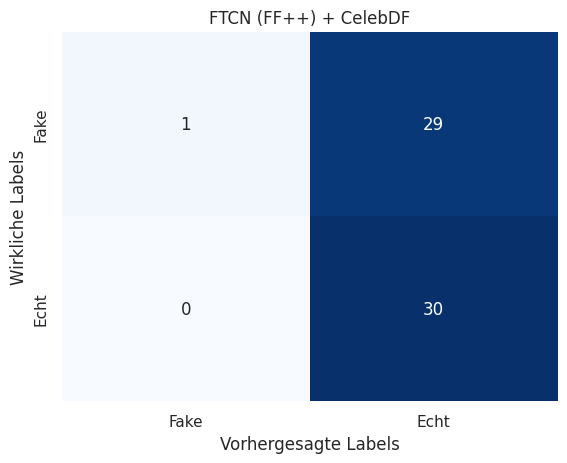

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(confusion_matrix, annot=True, fmt='.0f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'{net_model} ({train_db}) + {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()

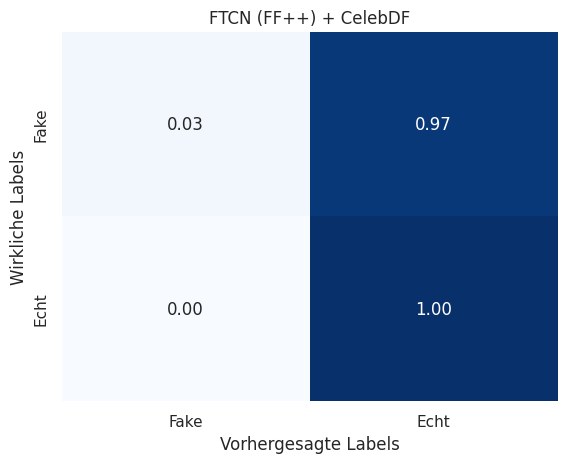

In [ ]:
# Labels for the classes
labels = ["Fake", "Echt"]

# Create a heatmap
sns.set(color_codes=False)
sns.heatmap(normalized_confusion_matrix, annot=True, fmt='.2f', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)

plt.figure(1, figsize=(5,5))
plt.title(f'{net_model} ({train_db}) + {dataset}')
plt.ylabel("Wirkliche Labels")
plt.xlabel('Vorhergesagte Labels')
plt.show()